## **Waste classification with Transfer Learning (MobileNet V2 model)**

The project concerns waste classification to determine if it may be recycle or not based on their photos. In this approach we will use a transfer learning with pre-trained MobileNet V2 model to check if we will achieve a better results.

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. MobileNet V2 is a classification model developed by Google and it is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

**Data**

The dataset contains images divided into two classes: organic waste and recycle waste and it is split into train and test data. Training dataset contains 22564 images while test dataset 2513 images.

### **Import libraries and data**


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Read data:

In [ ]:
cd '/content/drive/My Drive/Kaggle'

/content/drive/My Drive/Kaggle


In [ ]:
train_dir = '/content/drive/My Drive/Kaggle/DATASET/TRAIN'
test_dir = '/content/drive/My Drive/Kaggle/DATASET/TEST'

### **Data analysis**

The dataset contains images divided into training and test ones in jpg format.

The data include photos of the waste and there are 2 classes:  organic waste and recycle waste.

In [ ]:
class_names = os.listdir((train_dir))
print(f'Names of categories: {len(class_names)}')

Names of categories: 2


In [ ]:
count_train = {}
count_test = {}

for i in class_names:
    count_train[i] = len(os.listdir(os.path.join(train_dir, i)))
    count_test[i] = len(os.listdir(os.path.join(test_dir, i)))

print(f'Total number of images in train set: {sum(list(count_train.values()))}')
print(f'Total number of images in test set: {sum(list(count_test.values()))}')

Total number of images in train set: 22564
Total number of images in test set: 2513


Plot the number of images in train set:

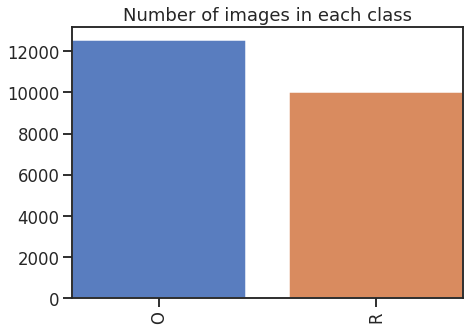

In [ ]:
sns.set_context('talk')
sns.set_palette(sns.color_palette('muted'))
sns.set_style('ticks')

plt.figure(figsize=(7, 5))
sns.barplot(x=list(count_train.keys()), y=list(count_train.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

Plot the number of images in test set:

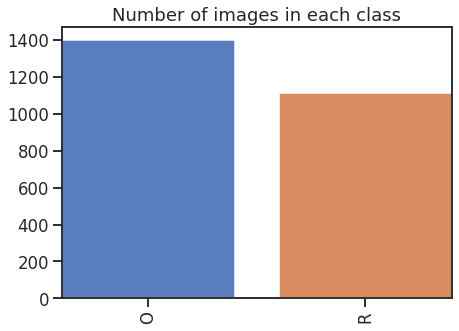

In [ ]:
sns.set_context('talk')
sns.set_palette(sns.color_palette('muted'))
sns.set_style('ticks')

plt.figure(figsize=(7, 5))
sns.barplot(x=list(count_test.keys()), y=list(count_test.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

### **Data preparation**

We add data augumentation to our dataset. We use ImageDataGenerator to create a transformation that rescales the images and applied data augmentation as well. We generate augumentation only for train data while validation data are only rescaling ones.

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   validation_split=0.2)


val_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split=0.5)

Now we divide the data into training, validation and test sets and change the image size to 128.

We use the flow_from_directory() method which allows to read the images directly from the directory and augment them while the neural network model is learning on the training data.


In [ ]:
batch_size = 32
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(train_dir, 
                                              class_mode='binary',
                                              batch_size = batch_size,
                                              target_size=img_size)

test_set = val_datagen.flow_from_directory(test_dir, 
                                           class_mode = 'binary',
                                           batch_size = batch_size, 
                                           target_size=img_size,
                                           subset= 'training')

val_set = val_datagen.flow_from_directory(test_dir, 
                                          class_mode='binary',
                                          batch_size = batch_size,
                                          subset = 'validation',
                                          target_size=img_size)
   

Found 22564 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.


In [ ]:
train_set.class_indices

{'O': 0, 'R': 1}

In [ ]:
train_set.image_shape

(128, 128, 3)

In [ ]:
test_set.image_shape

(128, 128, 3)

### **Creating the model**

We build model by using transfer learning with pre-trained MobileNet V2 model.

First we create the base MobileNetV2 model:

In [ ]:
img_shape = (128,128,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False, 
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


Next we freeze the convolutional layers to use the base model as a feature extractor:

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

**Model 1**

The model 1 consists of Flatten layer, then we added two Dense layers with one Dropout layer as well.

In [ ]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1, activation="sigmoid")                                     
                             ])

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

We train the model for 10 epoch:

In [ ]:
steps_per_epoch=int(len(train_set)/batch_size)

In [ ]:
history = model.fit(
    train_set, per_epoch,
    verbose=1
)

Epoch 1/10
22/22 [==============================] - 613s 29s/step - loss: 0.6752 - accuracy: 0.7614 - val_loss: 0.3764 - val_accuracy: 0.8089
Epoch 2/10
22/22 [==============================] - 211s 10s/step - loss: 0.3595 - accuracy: 0.8452 - val_loss: 0.3066 - val_accuracy: 0.8503
Epoch 3/10
22/22 [==============================] - 201s 9s/step - loss: 0.3249 - accuracy: 0.8565 - val_loss: 0.2845 - val_accuracy: 0.8893
Epoch 4/10
22/22 [==============================] - 198s 9s/step - loss: 0.3218 - accuracy: 0.8679 - val_loss: 0.3137 - val_accuracy: 0.8909
Epoch 5/10
22/22 [==============================] - 191s 9s/step - loss: 0.3177 - accuracy: 0.8438 - val_loss: 0.3502 - val_accuracy: 0.8432
Epoch 6/10
22/22 [==============================] - 180s 8s/step - loss: 0.2891 - accuracy: 0.8778 - val_loss: 0.2995 - val_accuracy: 0.8694
Epoch 7/10
22/22 [==============================] - 175s 8s/step - loss: 0.3018 - accuracy: 0.8736 - val_loss: 0.2894 - val_accuracy: 0.8774
Epoch 8/10


**Visualization training results**

The plots of loss and accuracy on the training and validation sets:


In [ ]:
# plot function
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

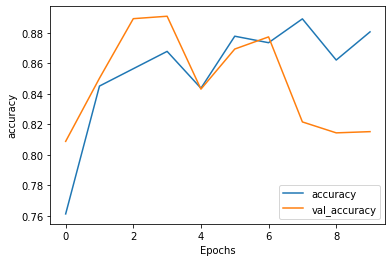

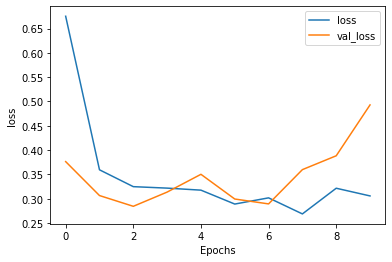

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Prediction for model 1:**

In [ ]:
loss, accuracy = model.evaluate(test_set, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8274


In [ ]:
# save model
model.save("tf_model.h5")

In this approach one can notice that the training and validation accuracy is increasing together and start to decreasing after 4 epoch. The similar situation takes place in the case of training and validation loss. One can also see a little bit of overfitting. On the test data we achieved 83% accuracy.  However we will check if we can improve its accuracy in the next model.

**Model 2**

In model two we change a bit architecture of our model, changing number of neurons in Dense layer.

In [ ]:
model2 = tf.keras.Sequential([base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1, activation="sigmoid")                                     
                             ])

In [ ]:
model2.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history2 = model2.fit(
    train_set,
    epochs = 10,
    validation_data = val_set,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Epoch 1/10
22/22 [==============================] - 268s 12s/step - loss: 1.0894 - accuracy: 0.6236 - val_loss: 0.4341 - val_accuracy: 0.7986
Epoch 2/10
22/22 [==============================] - 258s 12s/step - loss: 0.3437 - accuracy: 0.8580 - val_loss: 0.2545 - val_accuracy: 0.8909
Epoch 3/10
22/22 [==============================] - 255s 12s/step - loss: 0.3544 - accuracy: 0.8480 - val_loss: 0.2641 - val_accuracy: 0.8973
Epoch 4/10
22/22 [==============================] - 238s 11s/step - loss: 0.2813 - accuracy: 0.8793 - val_loss: 0.2857 - val_accuracy: 0.8678
Epoch 5/10
22/22 [==============================] - 235s 11s/step - loss: 0.2696 - accuracy: 0.8991 - val_loss: 0.2085 - val_accuracy: 0.9244
Epoch 6/10
22/22 [==============================] - 223s 10s/step - loss: 0.2787 - accuracy: 0.8849 - val_loss: 0.2198 - val_accuracy: 0.9268
Epoch 7/10
22/22 [==============================] - 222s 10s/step - loss: 0.3144 - accuracy: 0.8807 - val_loss: 0.2470 - val_accuracy: 0.8901
Epoch 

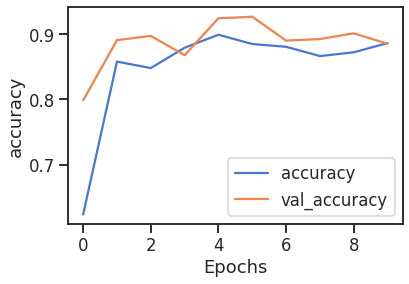

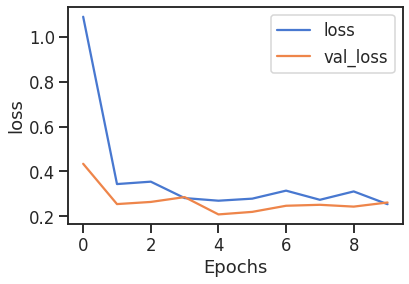

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [ ]:
loss, accuracy = model2.evaluate(test_set, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8839


In [ ]:
model2.save("tf_model_2.h5")

In the second model we have achieved a better result than in the first one. The training graphs show that the model was able to converge. The training and validation accuracy is increasing together and the same one can see in the case of the training and validation loss. It also decreased of overfitting. The accuracy of the test set was at the level of 88% and was also better compared to the model 1.

### **Summary**

In this approach we have used a pretrained MobileNetV2 model to resolve our image classification problem. From received analysis we can see that the second model is better than first one. By virtue the transfer learning and changing the architecture a little bit it was possible to obtain a model with better accuracy.